# Credit Card Fraud Detection
by **Sai Vamsy Dhulipala**

## Part IV - Model Building using Linear SVC

## Importing necessary packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 400)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
%matplotlib inline

In [3]:
from os import chdir, getcwd
import pickle

In [4]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import RFECV

## Importing the data

### Defining a function to read the data

In [5]:
def read_resampled_data(name):
    file = pickle.load(open(getcwd() + "/data/resampled_data/" + name + "_resampled.pkl","rb"))
    return file

### Reading the data

In [6]:
folder_path = input("Please provide the path of the folder, by replacing \\ as /:")
chdir(folder_path)

In [7]:
X_resampled = read_resampled_data("X")
y_resampled = read_resampled_data("y")

## Model building

### Defining a function to print the grid scores from RFECV

In [8]:
def plot_rfe_result(grid_scores):
    
    fig, ax = plt.subplots(figsize=(15,5))

    plt.plot(grid_scores)

    ax.set_xlabel("Features")
    ax.set_ylabel("Recall")

    fig.show()

### Linear SVC

The C parameter has been set to 0.0001 after performing Grid Search CV. The same has not been included in this notebook due to computational constraints.

In [9]:
svc = LinearSVC(
    dual=False,
    verbose=2,
    C=0.0001,
    random_state=42,
)

#### Performing RFECV to select the optimal features for modeling

In [10]:
rfecv_svc = RFECV(
    estimator=svc,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

In [11]:
rfecv_svc = rfecv_svc.fit(X_resampled, y_resampled)

Fitting estimator with 68 features.
[LibLinear]Fitting estimator with 67 features.
[LibLinear]Fitting estimator with 66 features.
[LibLinear]Fitting estimator with 65 features.
[LibLinear]Fitting estimator with 64 features.
[LibLinear][LibLinear][LibLinear]

<ipython-input-8-fa9cc244fc19>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


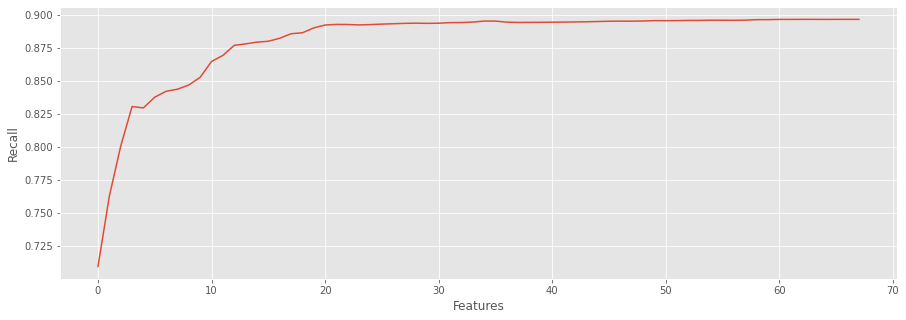

In [12]:
plot_rfe_result(rfecv_svc.grid_scores_)

In [13]:
cols_svc = rfecv_svc.support_
print(f"Optimal features: {cols_svc.sum()}")

Optimal features: 63


#### Model building using the selected columns with stratified k-fold CV

In [14]:
svc_cv = cross_validate(
    svc,
    X_resampled[:,cols_svc],
    y_resampled,
    verbose=1,
    return_train_score=True,
    n_jobs=-1,
    return_estimator=True,
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.5s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


In [15]:
print(svc_cv["test_score"])

[0.89931006 0.89894456 0.89993485 0.89899668 0.89699655]


In [16]:
svc_best = svc_cv["estimator"][svc_cv["test_score"].argmax()]

## Saving the data into pickle files

In [17]:
for f, file_name in (svc_best, "svc"), (cols_svc, "cols_svc"):
    pickle.dump(f, open(getcwd() + "/data/models/" + file_name + ".pkl", "wb"))
    del f

### Deleting all the variables present in the memory

In [18]:
%reset -f